In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft
from scipy.io import wavfile

from tensorflow.keras.models import *

In [2]:
highpass=25

class StreamSpectrogram:
    
    def __init__(self, filename, win=128):
        self.fs, self.data = wavfile.read(filename)
        if len(self.data.shape) > 1:
            self.data = self.data[:, 0]    
        self.win = win

    def x(self):
        spec  = fwd_spectrogram(self.data, win=512 + 2 * highpass)[:, 0:256] 
        t, d = spec.shape
        for i in range(self.win, t, self.win // 10):
            x      = np.reshape(spec[i - self.win:i], (self.win, d, 1))
            mu     = np.mean(x)
            std    = np.std(x) + 1.0
            window = (x - mu) / std
            yield window
            
def fwd_spectrogram(audio, win=512, step=64):
    '''
    Compute the spectrogram of audio data

    audio: one channel audio
    win: window size for dft sliding window
    step: step size for dft sliding windo
    '''
    spectrogram = []
    hanning = np.hanning(win)
    for i in range(win, len(audio), step):
        start = win // 2        
        dft = np.abs(fft(audio[i - win: i] * hanning))[start:win]
        spectrogram.append(dft)
    return np.array(spectrogram)

In [3]:
PATH = '../data/catalogue/whistle_snippets/'
encoder = load_model('../models/convnet_v5/encoder.h5')
latent = []
for file in os.listdir(PATH):
    if file.endswith('.wav'):
        p = "{}{}".format(PATH, file)
        spec = StreamSpectrogram(p)
        x = [x for x in spec.x()]
        if len(x) > 0:
            latent.append([encoder.predict(np.stack(x)), spec.data])
            print(latent[-1][0].shape)

W1106 10:43:29.402544 4651341248 hdf5_format.py:171] No training configuration found in save file: the model was *not* compiled. Compile it manually.


(12, 128)
(4, 128)
(8, 128)
(8, 128)
(7, 128)
(7, 128)
(9, 128)
(5, 128)
(69, 128)
(30, 128)
(49, 128)
(66, 128)
(9, 128)
(22, 128)
(16, 128)
(2, 128)
(9, 128)
(1, 128)
(6, 128)
(10, 128)
(1, 128)
(1, 128)
(2, 128)
(25, 128)
(3, 128)
(11, 128)
(49, 128)
(11, 128)
(6, 128)
(30, 128)
(3, 128)
(22, 128)
(1, 128)
(1, 128)
(2, 128)
(12, 128)


In [4]:
import pickle
pickle.dump( latent, open( "data.p", "wb" ) )

In [5]:
%load_ext Cython

In [6]:
%%cython
import pickle
import numpy as np
import matplotlib.pyplot as plt
cimport numpy as np

DTYPE = np.float

cdef double euc(np.ndarray x, np.ndarray y):
    return np.sqrt(np.sum(np.square(x - y)))

cdef double min3(float x, float y, float z):
    cdef float minimum = x
    if y < minimum:
        minimum = y
    if z < minimum:
        minimum = z
    return minimum

cdef double dtw(np.ndarray x, np.ndarray y):
    cdef int n = x.shape[0]
    cdef int m = y.shape[0]
    cdef int w = max(round((n + m) / 4), abs(n - m) + 2)
    
    cdef np.ndarray dp = np.ones((n + 1, m + 1)) * float('inf')
    cdef int i,j
    dp[0,0] = 0.0
    for i in range(1, n + 1):
        for j in range(max(1, i-w), min(m + 1, i+w)):
            dp[i][j] = euc(x[i - 1, :], y[j - 1, :]) + min3(
                dp[i - 1][j - 1],
                10 + dp[i - 1][j    ],
                10 + dp[i    ][j - 1]
            )
    if np.isinf(dp[n][m]):
        print('\t\tERROR: inf in warping')
    return dp[n][m] / (n + m)

latent = pickle.load( open( "data.p", "rb" ) )
print(len(latent))
n = len(latent)
distances = np.ones((n, n)) * float('inf')
for i, x in enumerate(latent):
    if i % 10 == 0:
        print("{} / {}".format(i, n))
    for j, y in enumerate(latent):
        distances[i][j] = dtw(x[0], y[0])
pickle.dump(distances, open( "distances.p", "wb" ) )

36
0 / 36
10 / 36
20 / 36
30 / 36


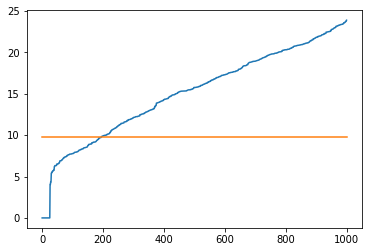

9.722695332307081


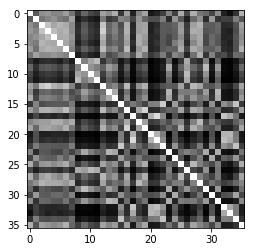

In [7]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import random

latent    = pickle.load( open( "data.p", "rb" ) )
distances = pickle.load( open( "distances.p", "rb" ) )

f = [f for f in distances.flatten() if not np.isinf(f)]
random.shuffle(f)
th = np.percentile(f, 20)

plt.plot(sorted(f[0:1000]))
plt.plot(np.ones(1000) * th)
plt.show()
print(th)

for i in range(len(distances)):
    for j in range(len(distances)):
        if np.isinf(distances[i][j]):
            distances[i][j] = distances[j][i]

plt.imshow(np.mean(distances) - distances, cmap='gray')
plt.show()

In [8]:
pickle.dump(distances, open( "distances_normal.p", "wb" ) )

In [9]:
import sklearn
from sklearn.cluster import AgglomerativeClustering

In [10]:
ac = AgglomerativeClustering(
    n_clusters=None, 
    affinity='precomputed', 
    linkage='average', 
    distance_threshold=th
)
clusters = ac.fit_predict(distances)

In [11]:
c = [[] for i in range(len(set(clusters)))]
for i, cluster_id in enumerate(clusters):
    c[cluster_id].append(latent[i][1])

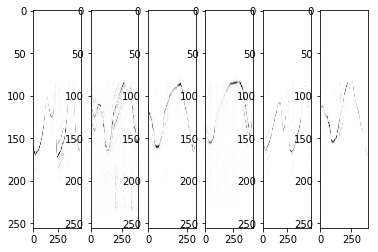

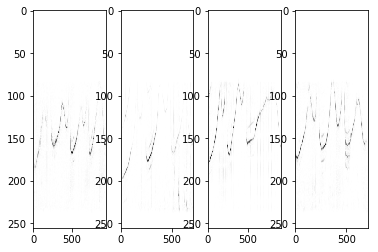

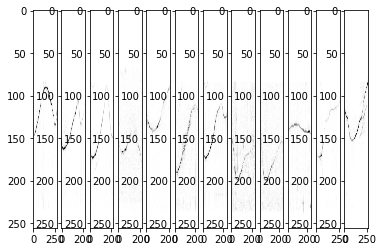

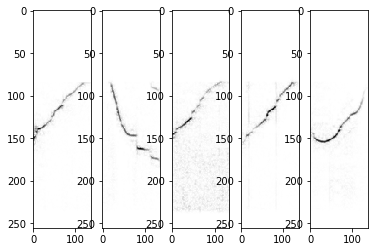

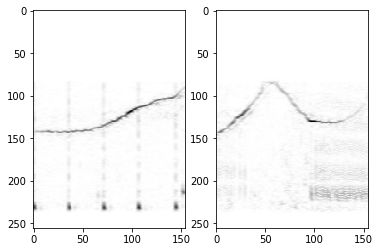

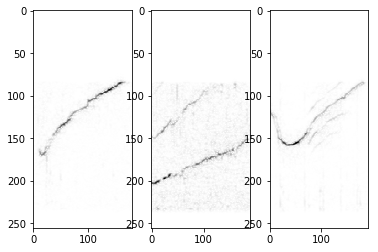

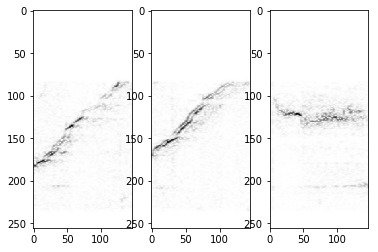

In [12]:
for cid, x in enumerate(c):
    if len(x) > 1:
        for i, a in enumerate(x):
            plt.subplot(1, len(x), i + 1)
            spec = fwd_spectrogram(a)
            plt.imshow(1.0 - spec.T, cmap='gray', aspect='auto')
        plt.savefig('{}.png'.format(cid))
        plt.show()
